## Find Fourier coefficients of initial surfaces

In [43]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from mem_curve import *

### Example Function

In [ ]:
# function
def Gaussian_2d(x,y):

    sigma_x = 1
    sigma_y = 1¶
    mu_x = 0
    mu_y = 0

    #return 1/( (2*np.pi*sigma_x*sigma_y)**0.5 ) * np.exp( -0.5 * ( (x-mu_x)*(y-mu_y) / (2*sigma_x*sigma_y) ) )
    return 1/( 2*np.pi*sigma_x ) * np.exp( -0.5 * (x**2 + y**2)/sigma_x**2 )

### Attempt 1

In [ ]:
def compute_2d_fourier_coeffs(func, Lx=1.0, Ly=1.0, M=3, N=3, Nx=256, Ny=256, x0=0.0, y0=0.0):
    x = x0 + (np.arange(Nx) / Nx) * Lx
    y = y0 + (np.arange(Ny) / Ny) * Ly
    X, Y = np.meshgrid(x, y, indexing='xy')
    F = func(X, Y)
    m_vals = np.arange(-(M//2), (M//2) + 1)
    n_vals = np.arange(-(N//2), (N//2) + 1)
    coefs = np.zeros((M, N), dtype=complex)
    factor = 1.0 / (Nx * Ny)
    for i, m in enumerate(m_vals):
        for j, n in enumerate(n_vals):
            exponent = np.exp(-2j * np.pi * (m * (X / Lx) + n * (Y / Ly)))
            coefs[i, j] = factor * np.sum(F * exponent)
    return coefs, m_vals, n_vals

def reconstruct_from_coefs(coeffs, m_vals, n_vals, Lx=1.0, Ly=1.0, x=None, y=None, x0=0.0, y0=0.0):
    if x is None:
        x = x0 + (np.arange(128) / 128) * Lx
    if y is None:
        y = y0 + (np.arange(128) / 128) * Ly
    X, Y = np.meshgrid(x, y, indexing='xy')
    out = np.zeros_like(X, dtype=complex)
    for i, m in enumerate(m_vals):
        for j, n in enumerate(n_vals):
            out += coeffs[i, j] * np.exp(2j * np.pi * (m * (X / Lx) + n * (Y / Ly)))
    return np.real(out), X, Y

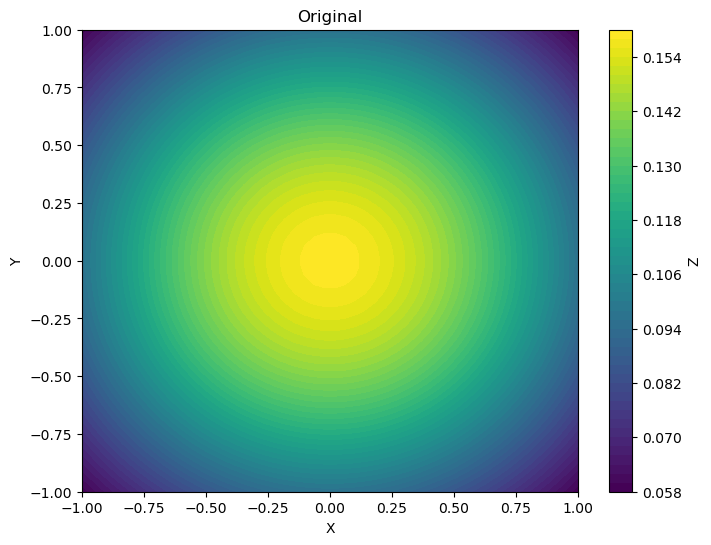

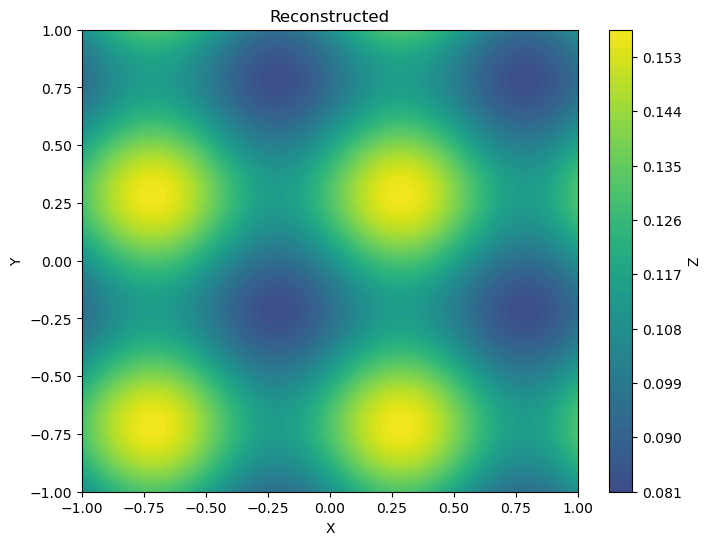

In [67]:
x = np.linspace(-1,1)
y = np.linspace(-1,1)
X, Y = np.meshgrid(x, y)

# # # Original # # #

Z = Gaussian_2d(X,Y)

# Animation plot
fig, ax = plt.subplots(figsize=[8, 6])

# Initial contour and colorbar
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis', vmin=np.min(Z), vmax=np.max(Z))
cbar = fig.colorbar(contour, ax=ax)

# Labels
cbar.set_label("Z")
ax.set_xlabel("X")
ax.set_ylabel("Y")
title = ax.set_title("Original")


# # # Reconstructed # # #

coeffs, m_vals, n_vals = compute_2d_fourier_coeffs(Gaussian_2d, Lx=1.0, Ly=1.0, M=3, N=3, Nx=256, Ny=256, x0=0.0, y0=0.0)

Z_new, X_new, Y_new = reconstruct_from_coefs(coeffs, m_vals, n_vals, x=x, y=y)

# Animation plot
fig, ax = plt.subplots(figsize=[8, 6])

# Initial contour and colorbar
contour = ax.contourf(X_new, Y_new, Z_new, levels=50, cmap='viridis', vmin=np.min(Z), vmax=np.max(Z))
cbar = fig.colorbar(contour, ax=ax)

# Labels
cbar.set_label("Z")
ax.set_xlabel("X")
ax.set_ylabel("Y")
title = ax.set_title("Reconstructed")

### Attempt 2

In [60]:
def compute_real_fourier_coeffs_2d(func, lx=1.0, ly=1.0, k=3, Nx=256, Ny=256):
    """
    Compute 2D real Fourier coefficients (α, β, γ, δ) for:
        h(x,y) = Σ_{n=0}^{k-1} Σ_{m=0}^{k-1} [ α_nm cos(2πnx/lx)cos(2πmy/ly)
                                              + β_nm cos(2πnx/lx)sin(2πmy/ly)
                                              + γ_nm sin(2πnx/lx)cos(2πmy/ly)
                                              + δ_nm sin(2πnx/lx)sin(2πmy/ly) ]

    Parameters
    ----------
    func : callable
        Function h(x,y) vectorized over numpy arrays.
    lx, ly : float
        Periods in x and y directions.
    k : int
        Number of Fourier modes in each direction (0..k-1).
    Nx, Ny : int
        Grid resolution for numerical integration.

    Returns
    -------
    alpha, beta, gamma, delta : (k, k) arrays of coefficients
    """

    x = np.linspace(-lx, lx, Nx, endpoint=False)
    y = np.linspace(-lx, ly, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing='xy')
    H = func(X, Y)

    alpha = np.zeros((k, k))
    beta = np.zeros((k, k))
    gamma = np.zeros((k, k))
    delta = np.zeros((k, k))

    dx = lx / Nx
    dy = ly / Ny

    # double integral normalization (1/(lx*ly)) approximated by sum * dx*dy
    norm = 1.0 / (lx * ly)
    for n in range(k):
        for m in range(k):
            cx = np.cos(2*np.pi*n*X/lx)
            sx = np.sin(2*np.pi*n*X/lx)
            cy = np.cos(2*np.pi*m*Y/ly)
            sy = np.sin(2*np.pi*m*Y/ly)

            alpha[n,m] = norm * np.sum(H * cx * cy) * dx * dy
            beta[n,m]  = norm * np.sum(H * cx * sy) * dx * dy
            gamma[n,m] = norm * np.sum(H * sx * cy) * dx * dy
            delta[n,m] = norm * np.sum(H * sx * sy) * dx * dy

    return alpha, beta, gamma, delta

In [61]:
# Example usage:
lx = 1.0
ly = 1.0


alpha, beta, gamma, delta = compute_real_fourier_coeffs_2d(Gaussian_2d, lx, ly, k=3)

print("alpha =\n", np.round(alpha, 3))
print("beta  =\n", np.round(beta, 3))
print("gamma =\n", np.round(gamma, 3))
print("delta =\n", np.round(delta, 3)) 

alpha =
 [[ 0.117 -0.002 -0.001]
 [-0.002  0.     0.   ]
 [-0.001  0.     0.   ]]
beta  =
 [[ 0. -0. -0.]
 [ 0.  0.  0.]
 [ 0. -0. -0.]]
gamma =
 [[ 0.  0.  0.]
 [ 0. -0.  0.]
 [ 0. -0. -0.]]
delta =
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


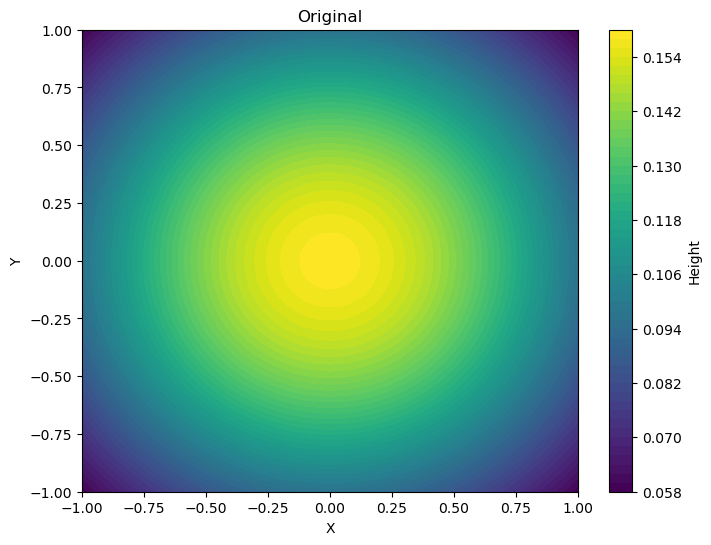

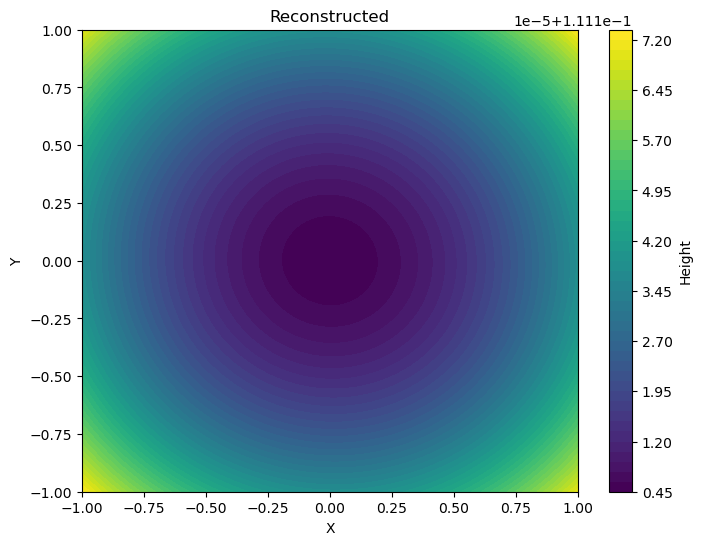

In [64]:
# Visualise 'initial surface'
# X,Y grid
npts = 100
x = np.linspace(-1, 1, npts)
y = np.linspace(-1, 1, npts)
X, Y = np.meshgrid(x, y)

# # # Original # # #

Z = Gaussian_2d(X, Y)

# Animation plot
fig, ax = plt.subplots(figsize=[8, 6])

# Initial contour and colorbar
#maxval = np.max(Z) if np.max(Z)>abs(np.min(Z)) else np.min(Z)
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis', vmin=np.min(Z), vmax=np.max(Z))
cbar = fig.colorbar(contour, ax=ax)

# Labels
cbar.set_label("Height")
title = ax.set_title("Original")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()


# # # Reconstructed # # #

# Calculate z-direction (heights)
init_membrane = {
    'alpha' : alpha,
    'beta'  : beta,
    'gamma' : gamma,
    'zeta'  : delta
    }

Z = calc_height(init_membrane, X, Y)

# Animation plot
fig, ax = plt.subplots(figsize=[8, 6])

# Initial contour and colorbar
#maxval = np.max(Z) if np.max(Z)>abs(np.min(Z)) else np.min(Z)
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis',  vmin=np.min(Z), vmax=np.max(Z))
cbar = fig.colorbar(contour, ax=ax)

# Labels
cbar.set_label("Height")
title = ax.set_title("Reconstructed")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

### Retrofit

Text(0, 0.5, 'Y')

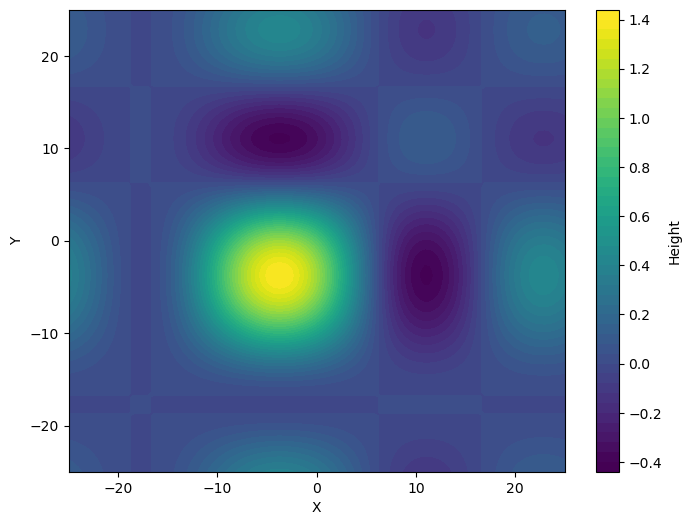

In [74]:
# Visualise 'initial surface'
# X,Y grid
npts = 100
x = np.linspace(-params.l_x/2, params.l_x/2, npts)
y = np.linspace(-params.l_y/2, params.l_y/2, npts)
X, Y = np.meshgrid(x, y)

# Calculate z-direction (heights)
init_membrane = {
    'alpha' : np.zeros((params.exp_order, params.exp_order)),
    'beta'  : np.zeros((params.exp_order, params.exp_order)),
    'gamma' : np.zeros((params.exp_order, params.exp_order)),
    'zeta'  : np.zeros((params.exp_order, params.exp_order))
    }

init_membrane['alpha'] += 1e-1
init_membrane['beta'] -= 1e-1
init_membrane['gamma'] -= 1e-1
init_membrane['zeta'] += 1e-1

Z = calc_height(init_membrane, X, Y)

# Animation plot
fig, ax = plt.subplots(figsize=[8, 6])

# Initial contour and colorbar
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis', vmin=np.min(Z), vmax=np.max(Z))
cbar = fig.colorbar(contour, ax=ax)

# Labels
cbar.set_label("Height")
#title = ax.set_title("Mean Membrane Height")
ax.set_xlabel("X")
ax.set_ylabel("Y")